In [24]:
import os
import sys
from pathlib import Path

In [25]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [26]:
from Bio import SeqIO
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules

In [27]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [28]:
macherry_file_path

'/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/mCherry_original.fasta'

In [29]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = str(list(mcherry_dict.values())[0].seq)

In [30]:
# default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
#         optimization_method="zscore_bulk_aa_ratio",
#         optimization_cub_index="CAI",
#         clusters_count=1,
#         tuning_param=0.5,
#         is_ecoli_optimized=True,
#         sequence=original_mcherry_seq,
#         output_path=Path(os.getcwd())/"play_results",
#         should_use_mrna_levels=False,
#         should_use_protein_abundance=True,
#     )
# default_user_inp_raw

In [31]:
# run_modules(user_input_dict=default_user_inp_raw, should_run_output_module=False)

# mCherry Variants Analysis

In [32]:
mcherry_variants_file_path = Path(base_path).parent.resolve() / "initiation_model_analysis" / "old_mcherry_variants.fasta"

In [33]:
with open(mcherry_variants_file_path, "r") as mcherry_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

## Whole prefix FE

In [34]:
num_of_codons = 11
num_of_codons_in_nt = num_of_codons * 3

In [35]:
from RNA import RNA 

In [36]:
original_mcherry_mfe =  RNA.fold(original_mcherry_seq[:num_of_codons_in_nt])[1]

In [37]:
original_mcherry_mfe

-3.0999999046325684

In [38]:
mfe_values = {}
for variant, variant_seq in mcherry_variants_dict.items():
    mfe_values[variant] = RNA.fold(str(variant_seq.seq)[:num_of_codons_in_nt])[1]

## Mean prefix FE

In [39]:
mcherry_plasmid_seq_file_path = Path(base_path).parent.resolve() / "initiation_model_analysis" / "AEC802-ECE15-P43_synthRBS_mCherry with Amp from Shira.fa"

In [40]:
with open(mcherry_plasmid_seq_file_path, "r") as mcherry_plasmid:
    mcherry_plasmid_dict = SeqIO.to_dict(SeqIO.parse(mcherry_plasmid, "fasta"))

In [41]:
mcherry_plasmid_seq = str(mcherry_plasmid_dict["AEC802-ECE15-P43_synthRBS_mCherry"].seq).lower()

In [42]:
orf_start_index = 560

prefix_end_index = orf_start_index + num_of_codons_in_nt
assert mcherry_plasmid_seq[orf_start_index:orf_start_index+len(original_mcherry_seq)] == original_mcherry_seq.lower()

In [43]:
mcherry_plasmid_seq[orf_start_index:orf_start_index+len(original_mcherry_seq)] 

'atggtttccaagggcgaggaggataacatggctatcattaaagagttcatgcgcttcaaagttcacatggagggttctgttaacggtcacgagttcgagatcgaaggcgaaggcgagggccgtccgtatgaaggcacccagaccgccaaactgaaagtgactaaaggcggcccgctgccttttgcgtgggacatcctgagcccgcaatttatgtacggttctaaagcgtatgttaaacacccagcggatatcccggactatctgaagctgtcttttccggaaggtttcaagtgggaacgcgtaatgaattttgaagatggtggtgtcgtgaccgtcactcaggactcctccctgcaggatggcgagttcatctataaagttaaactgcgtggtactaattttccatctgatggcccggtgatgcagaaaaagacgatgggttgggaggcgtctagcgaacgcatgtatccggaagatggtgcgctgaaaggcgaaattaaacagcgcctgaaactgaaagatggcggccattatgacgctgaagtgaaaaccacgtacaaagccaagaaacctgtgcagctgcctggcgcgtacaatgtgaatattaaactggacatcacctctcataatgaagattatacgatcgtagagcaatatgagcgcgcggagggtcgtcattctaccggtggcatggatgagctgtacaaataa'

In [44]:
# step_size_in_nt = 9 # 3 codons at a time
window_size_in_nt = 40

seqs = []
for i in range(orf_start_index - window_size_in_nt + 1 , orf_start_index + window_size_in_nt - 1):
    tmp_str = mcherry_plasmid_seq[i: i+window_size_in_nt]
    tmp_fe = RNA.fold(tmp_str)[1]
    seqs.append(tmp_fe)
    # print(f"FE {tmp_fe} for start ind {i-mid}, end ind {i+mid}: {tmp_str}")
original_mcherry_mfe = sum(seqs)/len(seqs)
original_mcherry_mfe

-3.865384592459752

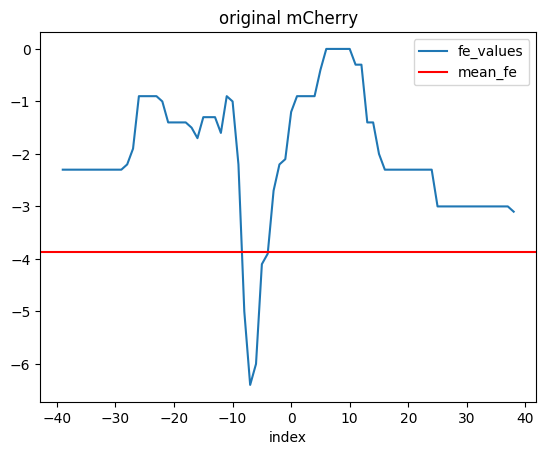

In [85]:
mcherry_fe_df = pd.DataFrame(data={"fe_values":seqs, "index":range(-39,39)})
plt = mcherry_fe_df.plot(x="index", y="fe_values", title = "original mCherry")
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="mean_fe")
plt.legend()

In [68]:
promoter = mcherry_plasmid_seq[orf_start_index-40: orf_start_index]
print(f"promoter: {promoter}")
mfe_values = {"variant":[], "mfe": [], "fe_values": []}
for variant, variant_seq in mcherry_variants_dict.items():
    seqs = []
    variant_seq_with_promoter = promoter + str(variant_seq.seq)
    variant_seq_with_promoter = variant_seq_with_promoter.lower()
    variant_orf_start_index = len(promoter)
    for i in range(variant_orf_start_index - window_size_in_nt + 1 , variant_orf_start_index + window_size_in_nt - 1):
        tmp_str = variant_seq_with_promoter[i: i+window_size_in_nt]
        tmp_fe = RNA.fold(tmp_str)[1]
        seqs.append(tmp_fe)
        # print(f"FE {tmp_fe} for start ind {i-mid}, end ind {i+mid}: {tmp_str}")
    avg_variant_fe = sum(seqs)/len(seqs)
    mfe_values["variant"].append(variant)
    mfe_values["mfe"].append(avg_variant_fe)
    mfe_values["fe_values"].append(seqs)
    # print(avg_variant_fe)

promoter: tgcacgaataaattagcaataaaaggaggttacagctagc


In [46]:
# TODO - take the original values and make sure they are identical

In [47]:
import pandas as pd

In [69]:
mfe_values_df = pd.DataFrame(mfe_values)

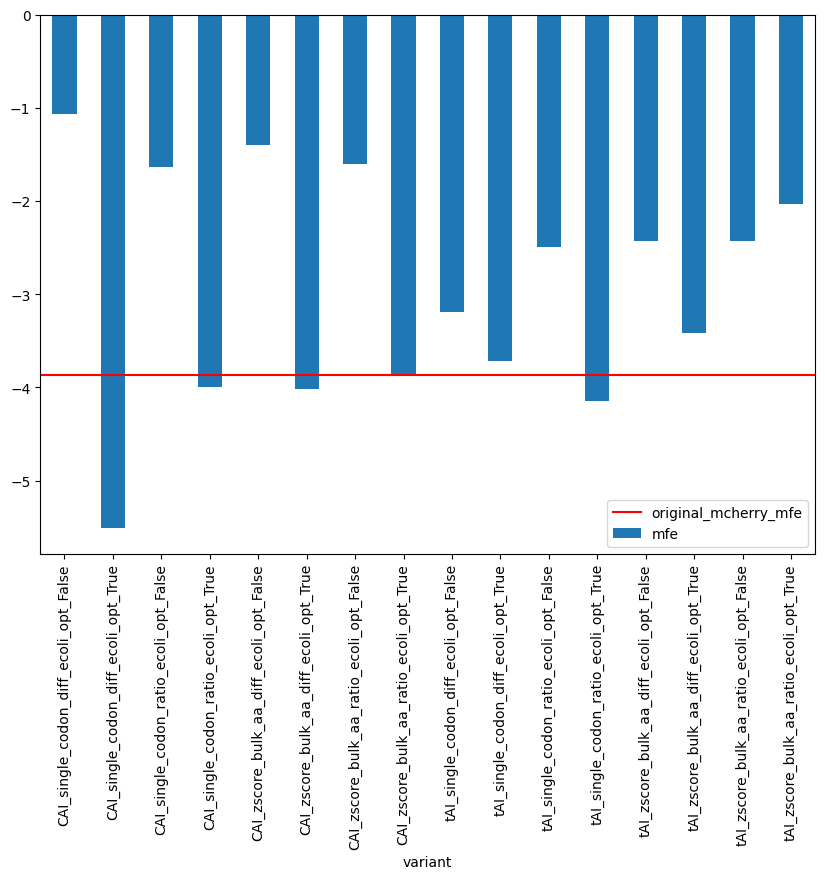

In [49]:
plt = mfe_values_df.plot("variant", "mfe", kind="bar", figsize=(10, 7))
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="original_mcherry_mfe")
plt.legend()

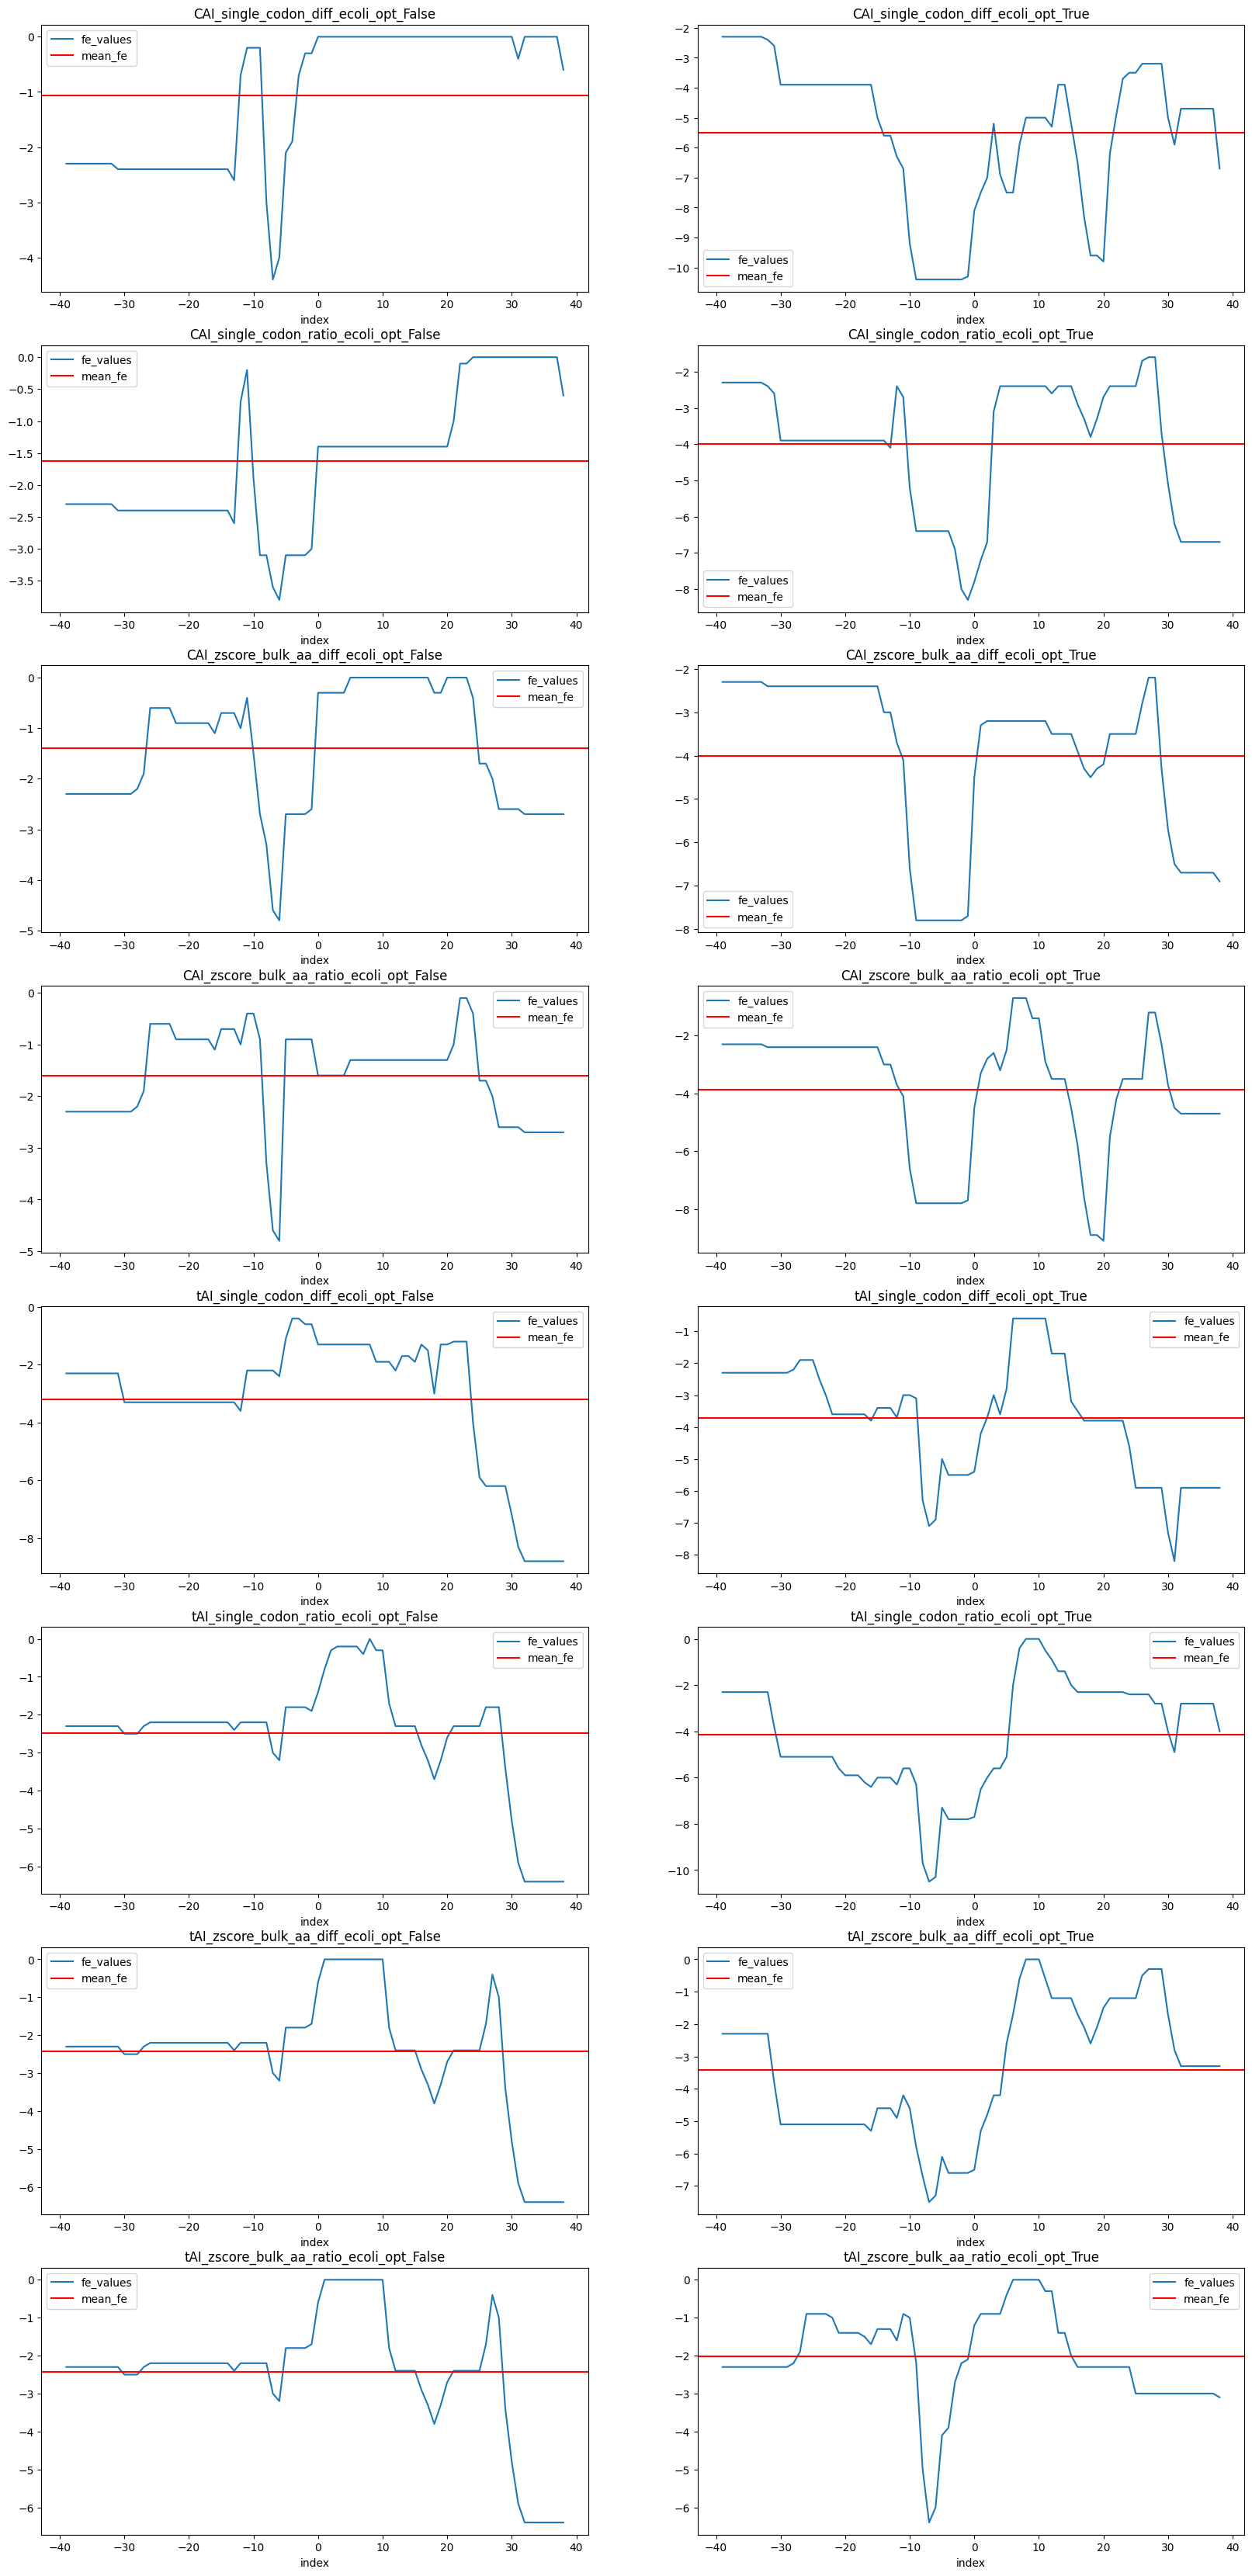

In [89]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(8, 2, figsize=(20,42))
for q in range(mfe_values_df.shape[0]):
    x= mfe_values_df.iloc[q, :]
    variant_df = pd.DataFrame(data={"fe_values":x["fe_values"], "index":range(-39,39)})
    plt = variant_df.plot(x="index", y="fe_values", title = x["variant"], ax=axis[q//2, q%2])
    plt.axhline(y=x["mfe"], color='r', linestyle='-', label="mean_fe")
    plt.legend()

In [73]:
x

variant                tAI_zscore_bulk_aa_ratio_ecoli_opt_True
mfe                                                  -2.028205
fe_values    [-2.299999952316284, -2.299999952316284, -2.29...
Name: 15, dtype: object

In [74]:
mfe_values_df

,variant,mfe,fe_values
0,CAI_single_codon_diff_ecoli_opt_False,-1.066667,"[-2.299999952316284, -2.299999952316284, -2.29..."
1,CAI_single_codon_diff_ecoli_opt_True,-5.507692,"[-2.299999952316284, -2.299999952316284, -2.29..."
2,CAI_single_codon_ratio_ecoli_opt_False,-1.630769,"[-2.299999952316284, -2.299999952316284, -2.29..."
3,CAI_single_codon_ratio_ecoli_opt_True,-4.000000,"[-2.299999952316284, -2.299999952316284, -2.29..."
4,CAI_zscore_bulk_aa_diff_ecoli_opt_False,-1.401282,"[-2.299999952316284, -2.299999952316284, -2.29..."
5,CAI_zscore_bulk_aa_diff_ecoli_opt_True,-4.014103,"[-2.299999952316284, -2.299999952316284, -2.29..."
6,CAI_zscore_bulk_aa_ratio_ecoli_opt_False,-1.607692,"[-2.299999952316284, -2.299999952316284, -2.29..."
7,CAI_zscore_bulk_aa_ratio_ecoli_opt_True,-3.862821,"[-2.299999952316284, -2.299999952316284, -2.29..."
8,tAI_single_codon_diff_ecoli_opt_False,-3.191026,"[-2.299999952316284, -2.299999952316284, -2.29..."
9,tAI_single_codon_diff_ecoli_opt_True,-3.717949,"[-2.299999952316284, -2.299999952316284, -2.29..."


## Matlab code

In [53]:
initiation_optimized_seq = "atggttTCAAAAGGGGAGGAGGACaacatggctatcattaaagagttcatgcgcttcaaagttcacatggagggttctgttaacggtcacgagttcgagatcgaaggcgaaggcgagggccgtccgtatgaaggcacccagaccgccaaactgaaagtgactaaaggcggcccgctgccttttgcgtgggacatcctgagcccgcaatttatgtacggttctaaagcgtatgttaaacacccagcggatatcccggactatctgaagctgtcttttccggaaggtttcaagtgggaacgcgtaatgaattttgaagatggtggtgtcgtgaccgtcactcaggactcctccctgcaggatggcgagttcatctataaagttaaactgcgtggtactaattttccatctgatggcccggtgatgcagaaaaagacgatgggttgggaggcgtctagcgaacgcatgtatccggaagatggtgcgctgaaaggcgaaattaaacagcgcctgaaactgaaagatggcggccattatgacgctgaagtgaaaaccacgtacaaagccaagaaacctgtgcagctgcctggcgcgtacaatgtgaatattaaactggacatcacctctcataatgaagattatacgatcgtagagcaatatgagcgcgcggagggtcgtcattctaccggtggcatggatgagctgtacaaataa"
initiation_optimized_seq_with_promoter = promoter + initiation_optimized_seq
initiation_optimized_seq_with_promoter = initiation_optimized_seq_with_promoter.lower()
mid= window_size_in_nt // 2
seqs = []
for i in range(len(promoter), len(promoter) + num_of_codons_in_nt - mid):
    tmp_str = initiation_optimized_seq_with_promoter[i-mid: i+mid]
    tmp_fe = RNA.fold(tmp_str)[1]
    seqs.append(tmp_fe)
    print(f"FE {tmp_fe} for start ind {i-mid}, end ind {i+mid}: {tmp_str}")
avg_fe = sum(seqs)/len(seqs)
avg_variant_fe

FE -0.6000000238418579 for start ind 20, end ind 60: aaaaggaggttacagctagcatggtttcaaaaggggagga
FE -0.6000000238418579 for start ind 21, end ind 61: aaaggaggttacagctagcatggtttcaaaaggggaggag
FE -0.6000000238418579 for start ind 22, end ind 62: aaggaggttacagctagcatggtttcaaaaggggaggagg
FE -0.6000000238418579 for start ind 23, end ind 63: aggaggttacagctagcatggtttcaaaaggggaggagga
FE -0.800000011920929 for start ind 24, end ind 64: ggaggttacagctagcatggtttcaaaaggggaggaggac
FE -0.4000000059604645 for start ind 25, end ind 65: gaggttacagctagcatggtttcaaaaggggaggaggaca
FE -0.4000000059604645 for start ind 26, end ind 66: aggttacagctagcatggtttcaaaaggggaggaggacaa
FE -0.4000000059604645 for start ind 27, end ind 67: ggttacagctagcatggtttcaaaaggggaggaggacaac
FE -0.699999988079071 for start ind 28, end ind 68: gttacagctagcatggtttcaaaaggggaggaggacaaca
FE -0.4000000059604645 for start ind 29, end ind 69: ttacagctagcatggtttcaaaaggggaggaggacaacat
FE -1.0 for start ind 30, end ind 70: tacagctagcatggtttcaaaagg

-2.0282051123869724

In [54]:
original_mcherry_matlab_mfe = -2.842424208467656

In [55]:
from scipy.io import savemat

In [56]:
base_data_path = Path("/tamir2/moranb/microbiome/folding_opt/promoters/data/mCherry")
for variant, variant_seq in mcherry_variants_dict.items():
    variant_orf_name = f"mCherry_{variant}"
    print(variant_orf_name)
    variant_dict = {"init_ORF": str(variant_seq.seq).lower(), "ORF_name": variant_orf_name}
    savemat(base_data_path/f"ORF_{variant_orf_name}.mat", variant_dict)

mCherry_CAI_single_codon_diff_ecoli_opt_False
mCherry_CAI_single_codon_diff_ecoli_opt_True
mCherry_CAI_single_codon_ratio_ecoli_opt_False
mCherry_CAI_single_codon_ratio_ecoli_opt_True
mCherry_CAI_zscore_bulk_aa_diff_ecoli_opt_False
mCherry_CAI_zscore_bulk_aa_diff_ecoli_opt_True
mCherry_CAI_zscore_bulk_aa_ratio_ecoli_opt_False
mCherry_CAI_zscore_bulk_aa_ratio_ecoli_opt_True
mCherry_tAI_single_codon_diff_ecoli_opt_False
mCherry_tAI_single_codon_diff_ecoli_opt_True
mCherry_tAI_single_codon_ratio_ecoli_opt_False
mCherry_tAI_single_codon_ratio_ecoli_opt_True
mCherry_tAI_zscore_bulk_aa_diff_ecoli_opt_False
mCherry_tAI_zscore_bulk_aa_diff_ecoli_opt_True
mCherry_tAI_zscore_bulk_aa_ratio_ecoli_opt_False
mCherry_tAI_zscore_bulk_aa_ratio_ecoli_opt_True


In [57]:
from scipy.io import loadmat
import glob

In [58]:
base_output_path = Path("/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry")

mfe_values = {"variant":list(mcherry_variants_dict.keys()), "mfe": []}

for i in range(1, 17):
    root_dir = base_output_path / str(i+1) 
    mat_file = glob.glob(f"{root_dir}/*.mat")[0]
    print(mat_file)
    result = loadmat(mat_file)
    mfe_values["mfe"].append(result["init_obj"][0][0])
    # mfe_values["fe_values"].append(seqs)

/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/2/mCherry mCherry_CAI_single_codon_diff_ecoli_opt_False mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/3/mCherry mCherry_CAI_single_codon_diff_ecoli_opt_True mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/4/mCherry mCherry_CAI_single_codon_ratio_ecoli_opt_False mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/5/mCherry mCherry_CAI_single_codon_ratio_ecoli_opt_True mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/6/mCherry mCherry_CAI_zscore_bulk_aa_diff_ecoli_opt_False mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/7/mCherry mCherry_CAI_zscore_bulk_aa_diff_ecoli_opt_True mCherry ORF.iter1.mat
/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/8/mCherry mCherry_CAI_zsc

In [59]:
mfe_values

{'variant': ['CAI_single_codon_diff_ecoli_opt_False',
  'CAI_single_codon_diff_ecoli_opt_True',
  'CAI_single_codon_ratio_ecoli_opt_False',
  'CAI_single_codon_ratio_ecoli_opt_True',
  'CAI_zscore_bulk_aa_diff_ecoli_opt_False',
  'CAI_zscore_bulk_aa_diff_ecoli_opt_True',
  'CAI_zscore_bulk_aa_ratio_ecoli_opt_False',
  'CAI_zscore_bulk_aa_ratio_ecoli_opt_True',
  'tAI_single_codon_diff_ecoli_opt_False',
  'tAI_single_codon_diff_ecoli_opt_True',
  'tAI_single_codon_ratio_ecoli_opt_False',
  'tAI_single_codon_ratio_ecoli_opt_True',
  'tAI_zscore_bulk_aa_diff_ecoli_opt_False',
  'tAI_zscore_bulk_aa_diff_ecoli_opt_True',
  'tAI_zscore_bulk_aa_ratio_ecoli_opt_False',
  'tAI_zscore_bulk_aa_ratio_ecoli_opt_True'],
 'mfe': [-1.100000017520153,
  -4.25606058583115,
  -1.6181818215232906,
  -3.0348485202500313,
  -0.9772727263696266,
  -2.819697011600841,
  -1.0621212011936938,
  -2.569697000763633,
  -1.7272727083076127,
  -2.2772727247440456,
  -1.3681818260387937,
  -3.6424242334835464,
  -1.3

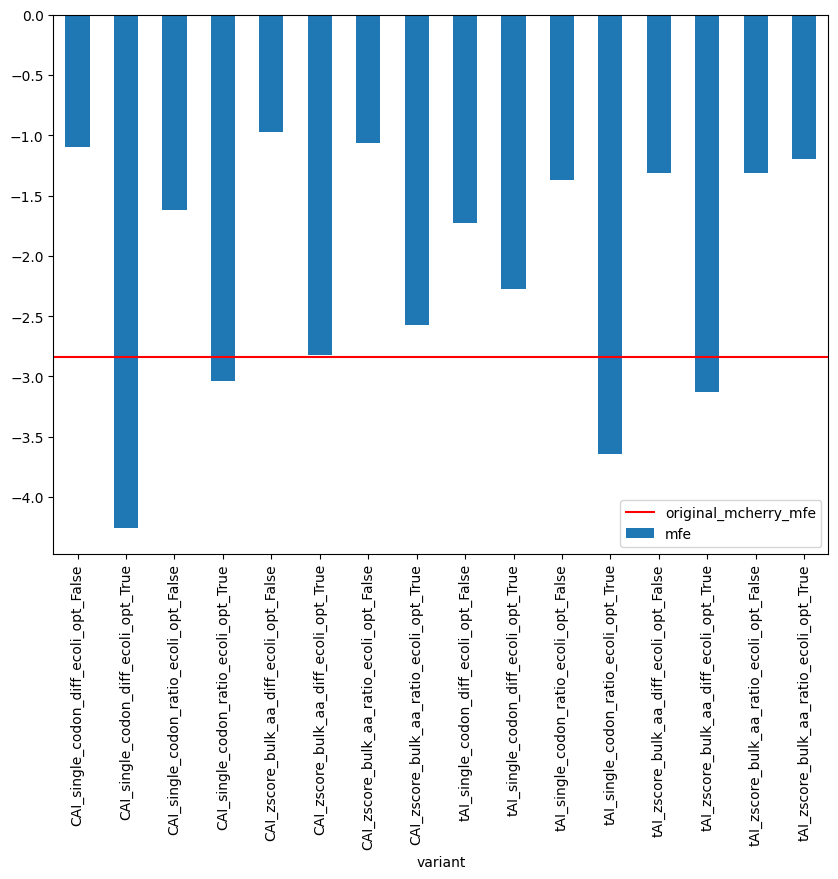

In [60]:
mfe_values_df = pd.DataFrame(mfe_values)
plt = mfe_values_df.plot("variant", "mfe", kind="bar", figsize=(10, 7))
plt.axhline(y=original_mcherry_matlab_mfe, color='r', linestyle='-', label="original_mcherry_mfe")
plt.legend()